In [6]:
#Import need libraries 

import numpy as np
import matplotlib.pyplot as plt

# Static Rocket Simulation

We want to simulate a rocket without any moving parts - first think about the different frames of referecene

A real rocket will have sensors telling it it's position, velocity, and acceleration, relative to itself, not relative to the ground - we want to work in two different coordinate framses

**Inertial Frame** - frame relative to the ground - origin is at the point of launch

**Body Frame** - frame relative to the rocket - origin is at the center of mass of the rocket

We look at the forces acting on the rocket using the inertial frame (it is easier to see what those are this way) and then translate them to the body frame to study the evolution of the rocket 

#### How to do this ?

We coudl try to use euler angles to describe the rotations, but this is messy and introduces gimble lock, where we can have two axis coinciding over each other thus making us loose some degrees of freedom. 

We will want to use quaternions instead

## What are quaternions ?

Quaterniosn are a mathematical tool invented by William Rowan Hamilton, it is a system qith 4 complex units and the same way that a multiplication by i is a 90º rotation, we can establish a relationship between these and 3D rotations. 

We can define a quaternion using a scalar and a 3D vector:

$ q = (a, \underline b) $ or using another notation $q = a + \underline b$ or $q = a + b_1 i + b_2 j + b_3 k$, where i,j, k are 3 independent complex numbers with the property : $ij = -ji = k, jk= -kj = i , ki = -ik = j $ and $i^2 = j^2 = k^2 = -1$

In this theory, vectors can be seen as pure quaternions

### Basic Properties of Quaternions 

**Addition** - $q_1 + q_2 = (a_1 + a_2, \underline b_1 + \underline b_2 )$

**Multiplication** - $q_1 q_2 = (a_1a_2 - \underline b_1 \cdot \underline b_2 , a_1 \underline b_2 + a_2 \underline b_1 + \underline b_1 \times \underline b_2)$

Now if we want to use quaternions we must define functions for these properties.

In [7]:
def quaternion_multiplication(q1, q2):
    
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_sum(q1, q2):

    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    
    return np.array([
        w1 + w2,
        -(x1 + x2),
        -(y1 + y2),
        -(z1 + z2)
    ]) 

## Quaternions and Rotations

Now we need to understand how quaternions can be translated into 3D rotations.

First, we can describe a vector in 3D using a quaternion by using pure quaternions $(0, \underline v)$. Using an unit quaternion we have a rotation operator $L(q) = q \underline v q^*$, where q is a unit quaternion described as $q = q_0 + \underline q = cos(\frac{\theta}{2} ) + sin(\frac{\theta}{2} )\underline \mu$

The equivalence between a quaternion ($q = (w,x,y,z)$) and a rotation matrix is given by such that $L(q) = R q$:

$$ R =  \begin{pmatrix}

    1 - 2 (y^2 +z^2) & 2(xy-zw) & 2(xz + yw) \\
    2(xy+zw) & 1 - 2 (x^2 +z^2) &  2(yz + xw) \\
    2(xz - yw) & 2(yz + xw) & 1 - 2 (x^2 +y^2)
\end{pmatrix} $$


This can be also written for a given axis with $q = cos(\frac{\theta}{2} ) + sin(\frac{\theta}{2} )\underline n$, where $\underline n$ is the vector director of the rotation axis, in such a way that :

$a = cos(\frac{\theta}{2} )$

$b = - n_x sin(\frac{\theta}{2} )$

$c = - n_y sin(\frac{\theta}{2} )$

$d = - n_z sin(\frac{\theta}{2} )$


$$ R =  \begin{pmatrix}

    a^2 + b^2 - c^2 - d^2 & 2(bc-ad) & 2(bd + ac) \\
    2(bc+ad) & a^2 + c^2 - b^2 - d^2  &  2(cd - ab) \\
    2(bd - ac) & 2(cd + ab) & a^2 + d^2 - b^2 - c^2 
\end{pmatrix} $$

In [8]:
def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    return np.array([
        [1-2*(y**2+z**2), 2*(x*y-w*z), 2*(x*z+w*y)],
        [2*(x*y+w*z), 1-2*(x**2+z**2), 2*(y*z-w*x)],
        [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x**2+y**2)]
    ])
    
def normalize_quaternion(q):
    return q / np.linalg.norm(q)

def axis_angle_rotation(axis, theta):
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2)
    b, c, d = -axis * np.sin(theta / 2)
    return np.array([
        [a*a + b*b - c*c - d*d, 2*(b*c - a*d), 2*(b*d + a*c)],
        [2*(b*c + a*d), a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
        [2*(b*d - a*c), 2*(c*d + a*b), a*a + d*d - b*b - c*c]
    ])


this is equivalent to have a rotation matrix around the 3 axis of the the rocket 

yaw 
pitch 
roll 
<img src="Rocket_diagram.webp" alt="Rocket Diagram" width="150"/>


Which means that we can also find a rotation matrix for angles around this body, using the roll ($\alpha$), yaw ($\beta$) and pitch ($\theta$) angles.

Equivalence between Euler Angles and Quaternions:

$$\alpha = tan^{-1} \left(\frac{2(q_2q_1 + q_3q_4)}{1 -2 (q_2^2 + q_3^2)}\right);

\beta = sin^{-1} (2(q_1q_3 - q_2q_4));  

\theta = tan^{-1} \left(\frac{2(q_1q_4 - q_3q_2)}{1 -2 (q_3^2 + q_4^2)}\right)$$

# Forces on the rocket and how to simulate them 

### What are the forces acting on the rocket ?

- Gravity 
- Drag 
- Lift
- Wind
- Initial force from the engine (determined by a trust profile - start by simulating it before implementing the real thing)

Don't forget you have the bottom fins at a fixed angle (I think for now I will ignore this but it could be relevant) as well as the movable fins at the top

So what are the equations we must obey ? - We need to consider the force on the rocket and the updates on the Inertial Frame, the angular velocities in the body frame as well as the evolution of the quaternion representing the rotation between the body frame and the 

Drag Equation : $$ F_{Drag} = \frac{1}{2} \rho v^2 A C_D sin(\theta)$$

$\rho$ - Air density , $v$ - velocity modulus  , $C_D$ - Drag Coefficient , $A$ - Surface Area exposed 

Lift Equation: $$F_{Lift} = \frac{1}{2} \rho v^2 A C_L sin(\theta)$$

$C_L$ - Lift Coefficient  

Air pressure relation to the amplitude: we know that it is an exponential relation and we also know that the pressure at sea level is 1.225 and 1000 is 1.112 so we can get the constant manualy. 

$$ \rho = \rho_0 exp(A y) \Rightarrow \rho \approx \rho_0 exp(\frac{y}{8500})  $$

so we have 3 types of kinematics :

- Translational Motion : $F_total = m \underline a$ , $\underline x = \underline x_0 + \underline v t + \frac{1}{2} a t^2$

- Rotational Motion: Euler equation $\underline G = \dot{L} + \underline \omega \times \underline L $, where L is the angular momentum in the Body frame ($\underline L = I \underline \omega$) and I is the moment of inertia tensor in the body frame, which means is a diagonal tensor, giving $\underline G = I \dot{\omega} + \underline \omega \times I \underline \omega $

- Quaternion motion : $\dot q = \frac{1}{2} q \cdot (0, \omega)$ , $q = q_0 + \Delta t \cdot \dot{q}$

we want to update all these EoM at each time step.

We use the quaternion to rotate the different forces that are better computed in the inertial frame, then calculate the Evolution of the CoM as well as the evolution of the Euler angles and the angular velocity to update the CoM position, the quaternion positon and the Euler Angles (later on that's what we actually want to minimize)



In [9]:
# set constants 

g = 9.81  # acceleration due to gravity in m/s^2
rho0 =  1.225  # density of air at seas level in kg/m^3

In [10]:
#Get a simulated thrust profile before finding the real one

def thrust_profile(t):
    if t < 3:
        return 15000
    elif t < 4:
        return 15000 * (4 - t)
    else:
        return 0

In [32]:
# What are the properties of the rocket ?

params = {
    'dry_mass': 50, # mass of rocket in KG 
    'fuel_initial': 20, # initial fuel mass in KG
    'burn_rate': 6.67,
    'I_body': np.diag([60, 60, 5]), # moment of inertia of the body in kg*m^2
    'Cd_body': 0.5,
    'Num_cannards': 4, # number of canards
    'A_ref': np.pi * (0.1)**2,
    'A_canard': 0.05,
    'thrust': thrust_profile,
    'canard_angles': np.radians([0, 0, 0, 0]), # angles of canards in radians, start by thinking about a static case
    'canard_vertical_position': 0.1, # vertical position of canards in meters
    'rocket_radius': 0.1, # radius of the rocket in meters
    'CP_R':[0.5, 0, 0] #Distance between the center of pressure and the center of mass in meters
}

In [38]:
# Now let's simulate the rocket dynamics 


# Just get a mock wid velocity function, later try yo include a the real one, potentially by integrating rocket pi 
def wind_velocity(y, t):
    
    return np.array([5 * (1 - np.exp(-y / 1000)), 0, 0])


def rocket_forces(t, state, params):
    
    #set up state variables
    position = state[0:3]
    velocity = state[3:6]
    q = state[6:10]
    angular_velocity = state[10:13]
    
    current_mass = params['dry_mass'] + max(0, params['fuel_initial'] - params['burn_rate'] * t)
    I_body = params['I_body']
    
    rho = rho0 * np.exp(-position[2] / 8500)  # density of air at altitude
    
    R = quaternion_to_rotation_matrix(q) #get rotation matrix from quaternion
    
    # Find the wind velocity in the body frame
    #wind_velocity_body = R.T @ (velocity - wind_velocity(position, t))
    
    altitude = position[2]
    wind_east = 5 * (1 - np.exp(-position[2] / 1000))
    wind = np.array([wind_east, 0, 0])
    wind_velocity_body = R.T @ (velocity - wind)  # wind velocity in the body frame
    
    wind_speed = np.linalg.norm(wind_velocity_body)
    if wind_speed < 1e-6:
        wind_speed = 1e-6
    
    # Aerodynamic angles
    #alpha = np.arctan2(v_air_body[2], v_air_body[0])
    #beta = np.arcsin(v_air_body[1] / v_mag)
    
    # Calculate all forces and moments in the body frame
    
    # Main body drag
    drag_body = -0.5 * rho * wind_speed * wind_velocity_body * params['Cd_body'] * params['A_ref']
    
    F_total = np.zeros(3)
    M_total = np.zeros(3)
    
    # Cannards Drag
    
    for i in range(params['Num_cannards']):
        
        azimuth = i * 2 * np.pi / params['Num_cannards']
        
        x = params['canard_vertical_position'] 
        y = params['rocket_radius'] * np.cos(azimuth)
        z = params['rocket_radius'] * np.sin(azimuth)
        canard_position = np.array([x, y, z])
        
        # along which plane is the cannard area going to point 
        canard_vector = np.array([0, np.cos(params['canard_angles'][i]), np.sin(params['canard_angles'][i])])
        #canard_vector = canard_vector / np.linalg.norm(canard_vector)
        
        M_canard = np.cross(canard_position, canard_vector)
        F_canard = -0.5 * rho * wind_speed**2 * params['A_canard'] * canard_vector
        F_total += F_canard
        M_total += M_canard
    
    # Gravity force
    F_gravity = np.array([0, 0, -current_mass * g])
    F_gravity = R.T @ F_gravity  # transform to body frame
    M_gravity = np.cross(params['CP_R'], F_gravity)  # moment due to gravity
    M_total += M_gravity
    F_total += F_gravity
    # Thrust force
    F_thrust = np.array([0, 0, params['thrust'](t)])  # thrust is in the z direction
    #No need for transformation to body frame, thrust is already in the body frame, it's easier to understand like that
    M_thrust = np.cross(params['CP_R'], F_thrust)  # moment due to thrust
    M_total += M_thrust
    # Add thrust force to total force
    F_total += F_thrust
    
    # Drag force on the body - Drag due to body surface against the air , should be agains the position of the direction of the rocket, moving up  
    # F_drag = drag_body * (position / np.linalg.norm(position))  # drag force in the body frame
    drag_body = -0.5 * rho * wind_speed * wind_velocity_body * params['Cd_body'] * params['A_ref'] # drag force in the body frame, we will calculate it later
    F_total += drag_body
    
    # Total force in the Inertial frame
    F_total_Inertial = R @ F_total
    
    a_world = F_total_Inertial / current_mass  # acceleration in the world frame
    q_dot = 0.5 *  quaternion_multiplication(q, np.concatenate(([0], angular_velocity)))
    omega_dot = np.linalg.inv(I_body) @ (M_total - np.cross(angular_velocity, I_body @ angular_velocity))  # angular acceleration in the body frame
    
    
    # Total moment in the body frame
    
    return velocity, a_world, q_dot, omega_dot

In [36]:
def simulate_rocket(t_final, dt, params):
    num_steps = int(t_final / dt)
    state = np.zeros((13, num_steps))  #[position, velocity, quaternion, angular_velocity]
    
    
    # state[6:10] = normalize_quaternion(np.array([1, 0, 0, 0]))  # initial quaternion
    # state[10:13] = np.array([0, 0, 0])  # initial angular velocity
    
    # trajectory = []
    
    state[:, 0] = np.concatenate([
        np.zeros(3),      # Position (world frame)
        np.zeros(3),      # Velocity (world frame)
        np.array([1,0,0,0]),               # Orientation quaternion
        np.zeros(3)       # Angular velocity (body frame)
    ])

    
    for step in range(1,num_steps):
        t = step * dt
        
        y_old = state[:, step - 1]
        
        # Unpack the state 
        pos = y_old[0:3]
        vel = y_old[3:6]
        q = y_old[6:10]
        omega = y_old[10:13]
        
        #Get the dynamics of the rocket at this time step
        
        velocity, a_world, q_dot, omega_dot = rocket_forces(t, y_old, params)
        
        old_state = state.copy()
        
     # Update state usinf Euler integration
     
        state[0:3, step] = pos + vel * dt  # Update position
        state[3:6, step] = vel + a_world * dt
        state[6:10, step] = normalize_quaternion(q + q_dot * dt)
        state[10:13, step] = omega + omega_dot * dt
    return state 

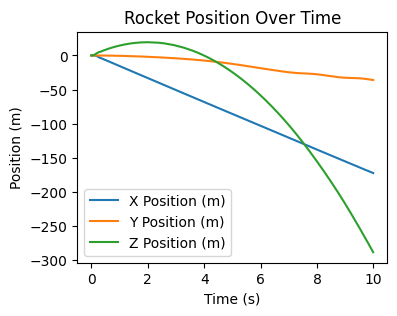

In [43]:
# Run the simulation
t_final = 10  # total simulation time in seconds
dt = 0.01  # time step in seconds
rocket_state = simulate_rocket(t_final, dt, params)
# Plot the results
plt.figure(figsize=(4, 3))
plt.plot(np.arange(0, t_final, dt), rocket_state[0, :], label='X Position (m)')
plt.plot(np.arange(0, t_final, dt), rocket_state[1, :], label='Y Position (m)')
plt.plot(np.arange(0, t_final, dt), rocket_state[2, :], label='Z Position (m)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Rocket Position Over Time')
plt.legend()

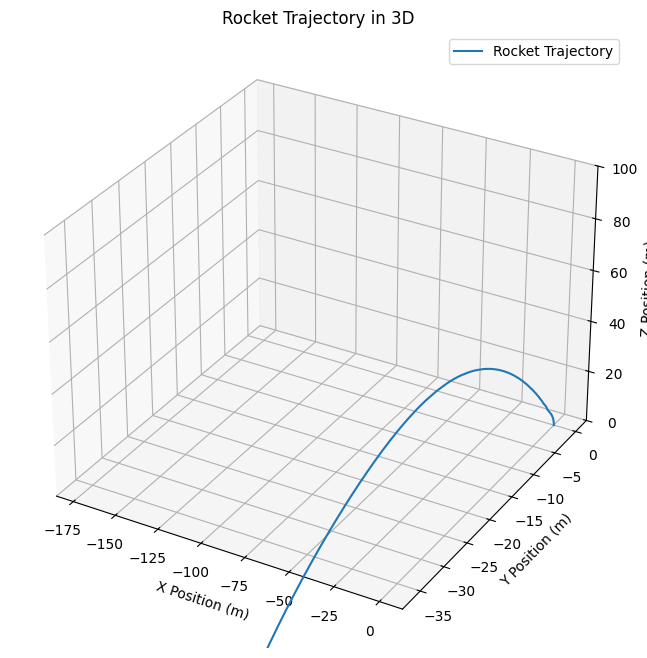

In [50]:
#try to get a 3D plot of the trajectory
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rocket_state[0, :], rocket_state[1, :], rocket_state[2, :], label='Rocket Trajectory')  
ax.set_zlim(0, 100)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('Rocket Trajectory in 3D')
plt.legend()
plt.show()

# Next Steps 

- Implement PID and vary angle 
- Get realistic values for our systems $C_D, C_l$, Areas, I
- Integrate windspeed from rocket pi so that it corresponds 

# Sources 

https://math.unm.edu/~vageli/courses/Ma375/literature/rrr.pdf 

https://leedsrocketry.co.uk/wp-content/uploads/2024/08/Canard-Control-Development.pdf

https://leedsrocketry.co.uk/wp-content/uploads/2024/08/Development-of-a-Canard-Controlled-Active-Stability-System-for-a-Sounding-Rocket.pdf

https://eater.net/quaternions

https://graphics.stanford.edu/courses/cs348a-17-winter/Papers/quaternion.pdf 

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0276302 

